In [4]:
print(1)

1


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [6]:
# Dataset Preparation
class ImageDataset(Dataset):
    def __init__(self, root_dir, scale_factor, num_samples=100):
        self.hr_images = sorted(os.listdir(root_dir))[:num_samples]
        self.root_dir = root_dir
        self.scale_factor = scale_factor
        self.transform_hr = transforms.Compose([
            transforms.Resize((1024, 1024), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.transform_lr = transforms.Compose([
            transforms.Resize((1024 // scale_factor, 1024 // scale_factor), Image.BICUBIC),
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_path = os.path.join(self.root_dir, self.hr_images[idx])
        hr_image = Image.open(hr_path).convert("RGB")
        lr_image = self.transform_lr(hr_image)
        hr_image = self.transform_hr(hr_image)
        return lr_image, hr_image

In [7]:
# Define Generator
import torch.nn.functional as F

class SRGAN_Generator(nn.Module):
    def __init__(self, scale_factor=2):
        super(SRGAN_Generator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Ensure output channels match the upscaling factor squared
        self.conv3 = nn.Conv2d(64, 3 * (scale_factor ** 2), kernel_size=3, padding=1)

        # Adjust PixelShuffle to upscale correctly
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pixel_shuffle(self.conv3(x))  # Ensure correct upscaling
        return x

In [8]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scale_factors = [2, 4, 8]
results = {}

for scale in scale_factors:
    print(f"\nTraining SRGAN for scale factor {scale}x...")
    
    dataset = ImageDataset(root_dir="/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR", scale_factor=scale, num_samples=100)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = SRGAN_Generator(scale_factor=scale).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for low_res, high_res in dataloader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    results[scale] = losses
    torch.save(model.state_dict(), f"srgan_generator_{scale}x.pth")


Training SRGAN for scale factor 2x...
Epoch [1/5], Loss: 0.2121
Epoch [2/5], Loss: 0.1562
Epoch [3/5], Loss: 0.0821
Epoch [4/5], Loss: 0.0340
Epoch [5/5], Loss: 0.0278

Training SRGAN for scale factor 4x...
Epoch [1/5], Loss: 0.2341
Epoch [2/5], Loss: 0.1901
Epoch [3/5], Loss: 0.1203
Epoch [4/5], Loss: 0.0562
Epoch [5/5], Loss: 0.0416

Training SRGAN for scale factor 8x...
Epoch [1/5], Loss: 0.2287
Epoch [2/5], Loss: 0.1840
Epoch [3/5], Loss: 0.1123
Epoch [4/5], Loss: 0.0623
Epoch [5/5], Loss: 0.0416


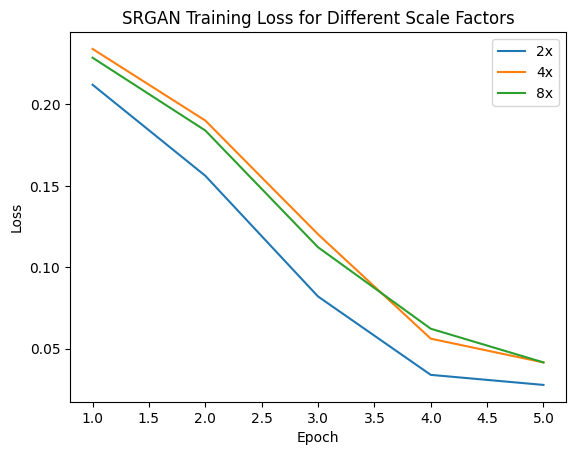

In [9]:
# Plot Loss Graphs
for scale, loss in results.items():
    plt.plot(range(1, len(loss)+1), loss, label=f'{scale}x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SRGAN Training Loss for Different Scale Factors")
plt.legend()
plt.show()

In [10]:
for low_res, high_res in dataloader:
    low_res, high_res = low_res.to(device), high_res.to(device)
    outputs = model(low_res)
    
    print(f"Low-Res Shape: {low_res.shape}")  # Should be (batch_size, 3, X, X)
    print(f"Generated Output Shape: {outputs.shape}")  # Should match high_res
    print(f"High-Res Shape: {high_res.shape}")  # Should be (batch_size, 3, 1024, 1024)

    break  # Check only one batch


Low-Res Shape: torch.Size([16, 3, 128, 128])
Generated Output Shape: torch.Size([16, 3, 1024, 1024])
High-Res Shape: torch.Size([16, 3, 1024, 1024])


In [14]:
!pip install torchmetrics
!pip install pytorch-msssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 12.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [15]:
import torchmetrics
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scale_factors = [2, 4, 8]
results = {}

# Define PSNR and SSIM metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

for scale in scale_factors:
    print(f"\nTraining SRGAN for scale factor {scale}x...")
    
    dataset = ImageDataset(root_dir="/kaggle/input/div2k-high-resolution-images/DIV2K_train_HR/DIV2K_train_HR", scale_factor=scale, num_samples=100)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    model = SRGAN_Generator(scale_factor=scale).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    num_epochs = 5
    losses, psnrs, ssims = [], [], []

    for epoch in range(num_epochs):
        epoch_loss, epoch_psnr, epoch_ssim = 0, 0, 0
        for low_res, high_res in dataloader:
            low_res, high_res = low_res.to(device), high_res.to(device)
            optimizer.zero_grad()
            
            # Generate high-res output
            outputs = model(low_res)

            # Compute Loss
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

            # Compute PSNR and SSIM
            psnr = psnr_metric(outputs, high_res)
            ssim = ssim_metric(outputs, high_res)

            # Accumulate metrics
            epoch_loss += loss.item()
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()

        # Average loss and metrics per epoch
        avg_loss = epoch_loss / len(dataloader)
        avg_psnr = epoch_psnr / len(dataloader)
        avg_ssim = epoch_ssim / len(dataloader)

        losses.append(avg_loss)
        psnrs.append(avg_psnr)
        ssims.append(avg_ssim)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f} dB, SSIM: {avg_ssim:.4f}")

    # Store results
    results[scale] = {"loss": losses, "psnr": psnrs, "ssim": ssims}
    
    # Save trained model
    torch.save(model.state_dict(), f"srgan_generator_{scale}x.pth")

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(



Training SRGAN for scale factor 2x...
Epoch [1/5], Loss: 0.2058, PSNR: 6.95 dB, SSIM: 0.0635
Epoch [2/5], Loss: 0.1620, PSNR: 7.98 dB, SSIM: 0.0974
Epoch [3/5], Loss: 0.1022, PSNR: 9.98 dB, SSIM: 0.1223
Epoch [4/5], Loss: 0.0516, PSNR: 12.93 dB, SSIM: 0.1260
Epoch [5/5], Loss: 0.0311, PSNR: 15.14 dB, SSIM: 0.1835

Training SRGAN for scale factor 4x...
Epoch [1/5], Loss: 0.2463, PSNR: 6.12 dB, SSIM: -0.0007
Epoch [2/5], Loss: 0.2197, PSNR: 6.64 dB, SSIM: 0.0371
Epoch [3/5], Loss: 0.1591, PSNR: 8.06 dB, SSIM: 0.0678
Epoch [4/5], Loss: 0.0858, PSNR: 10.76 dB, SSIM: 0.0674
Epoch [5/5], Loss: 0.0491, PSNR: 13.14 dB, SSIM: 0.0732

Training SRGAN for scale factor 8x...
Epoch [1/5], Loss: 0.2397, PSNR: 6.24 dB, SSIM: 0.0195
Epoch [2/5], Loss: 0.2092, PSNR: 6.85 dB, SSIM: 0.0537
Epoch [3/5], Loss: 0.1455, PSNR: 8.42 dB, SSIM: 0.0630
Epoch [4/5], Loss: 0.0751, PSNR: 11.36 dB, SSIM: 0.0552
Epoch [5/5], Loss: 0.0554, PSNR: 12.58 dB, SSIM: 0.0626


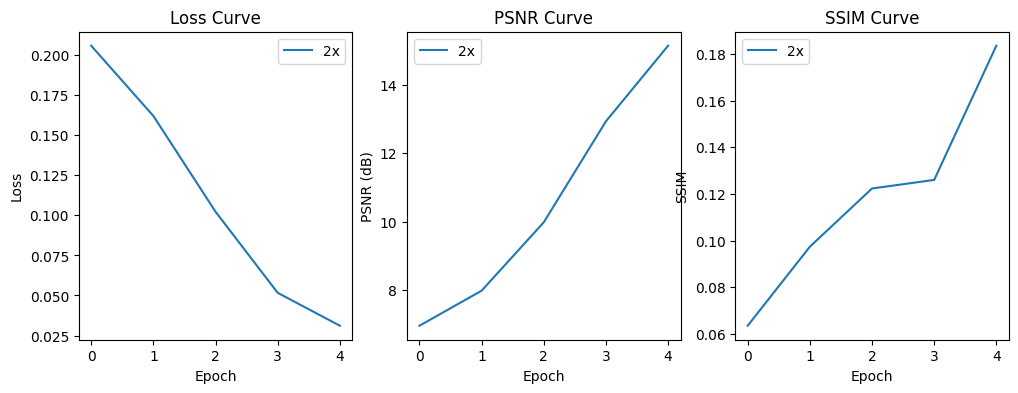

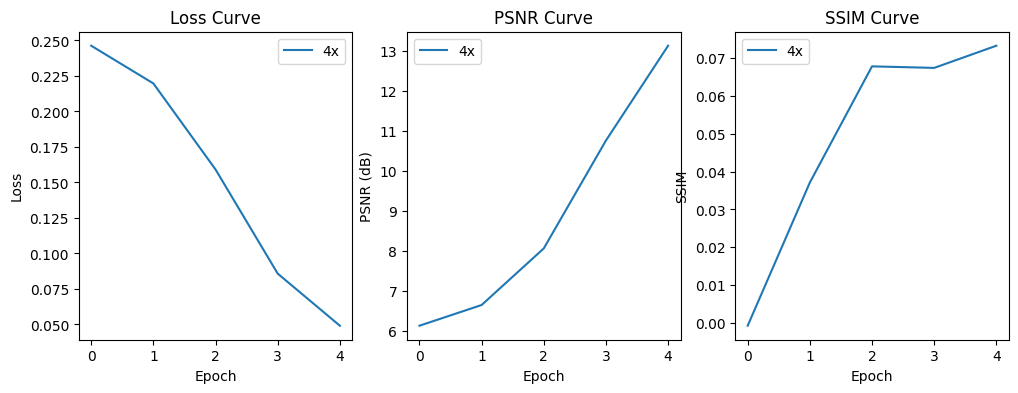

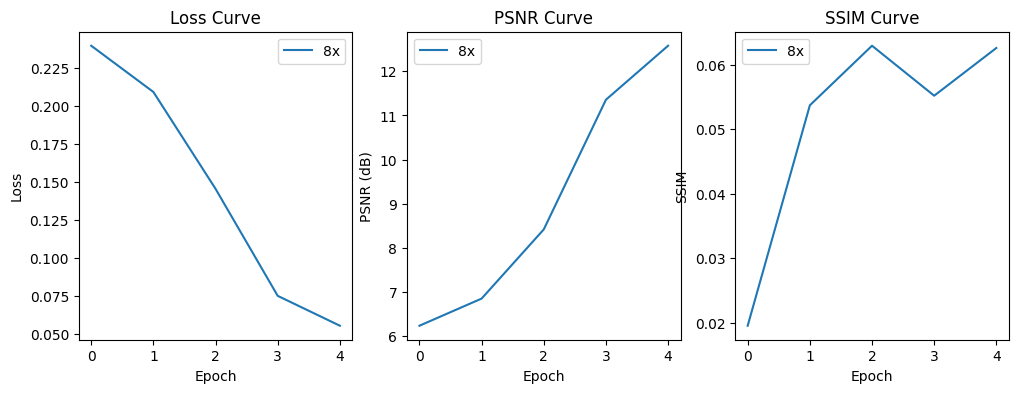

In [16]:
# Plot Loss, PSNR, and SSIM
import matplotlib.pyplot as plt

for scale in scale_factors:
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(results[scale]["loss"], label=f"{scale}x")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # PSNR Plot
    plt.subplot(1, 3, 2)
    plt.plot(results[scale]["psnr"], label=f"{scale}x")
    plt.xlabel("Epoch")
    plt.ylabel("PSNR (dB)")
    plt.title("PSNR Curve")
    plt.legend()

    # SSIM Plot
    plt.subplot(1, 3, 3)
    plt.plot(results[scale]["ssim"], label=f"{scale}x")
    plt.xlabel("Epoch")
    plt.ylabel("SSIM")
    plt.title("SSIM Curve")
    plt.legend()

    plt.show()